# Exploratory Analysis of Domestic Flights Arriving at LaGuardia

Data source:

Bureau of Transportation Statistics, United States Department of Transportation

https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

# Read the data into a single dataframe

Manually downloaded airline [On-Time Performance data set](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for every month from January 2016 through 2017 YTD as zip files to `data/flights/`.

Concatenate all of these files into a single data frame.

In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import re
import datetime
import calendar
%matplotlib inline

In [45]:
def read_flight_data(path_to_data):
    list_of_dataframes = []
    
    for filename in os.listdir(path_to_data):
        df = pd.read_csv(os.path.join(path_to_data, filename), compression='infer')
        list_of_dataframes.append(df)
    
    output = pd.concat(list_of_dataframes)
    
    # Drop any columns with "Unnamed" in the header
    drop_columns = [i for i in output.columns if 'Unnamed' in i]
    output = output.drop(drop_columns, axis=1)
    
    # Filter the data to only include flights arriving at LGA
    output = output[output['DEST'] == 'LGA']
    
    # Sort output by date and scheduled departure time
    output['FL_DATE'] = pd.to_datetime(output['FL_DATE'])
    output = output.sort_values(by=['FL_DATE', 'CRS_DEP_TIME'])
    output = output.reset_index(drop=True)
    
    return output     

In [46]:
df = read_flight_data("../raw_data/flights")

In [47]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY
0,2016,1,1,1,5,2016-01-01,NK,20416,NK,N641NK,...,22,546,NaN,NaN,NaN,NaN,NaN,850,NaN,NaN
1,2016,1,1,1,5,2016-01-01,NK,20416,NK,N636NK,...,22,600,624.0,24.0,24.0,740.0,8.0,735,748.0,13.0
2,2016,1,1,1,5,2016-01-01,B6,20409,B6,N623JB,...,22,600,556.0,-4.0,0.0,806.0,5.0,825,811.0,-14.0
3,2016,1,1,1,5,2016-01-01,B6,20409,B6,N599JB,...,22,600,553.0,-7.0,0.0,819.0,5.0,841,824.0,-17.0
4,2016,1,1,1,5,2016-01-01,AA,19805,AA,N3KRAA,...,22,605,714.0,69.0,69.0,947.0,5.0,857,952.0,55.0


# Exploratory Data Analysis

### How many flights arrive at LaGuardia per day?

In [48]:
def count_flights_per_day(df):
    flights_per_day = pd.DataFrame(columns = ['FL_DATE','NUM_FLIGHTS'])
    flights_per_day['FL_DATE'] = df['FL_DATE'].value_counts().index
    flights_per_day['NUM_FLIGHTS'] = df['FL_DATE'].value_counts().values
    flights_per_day = flights_per_day.sort_values(by='FL_DATE')
    flights_per_day = flights_per_day.reset_index(drop=True)
    
    # Plot number of arrivals at LGA per day
    ax = flights_per_day.plot(kind='bar', figsize=(60,20), title='Number of LGA Arrivals per Day Since Jan 2016')
    ax.set_xticklabels(flights_per_day['FL_DATE'].dt.date) # removes timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    
    return flights_per_day

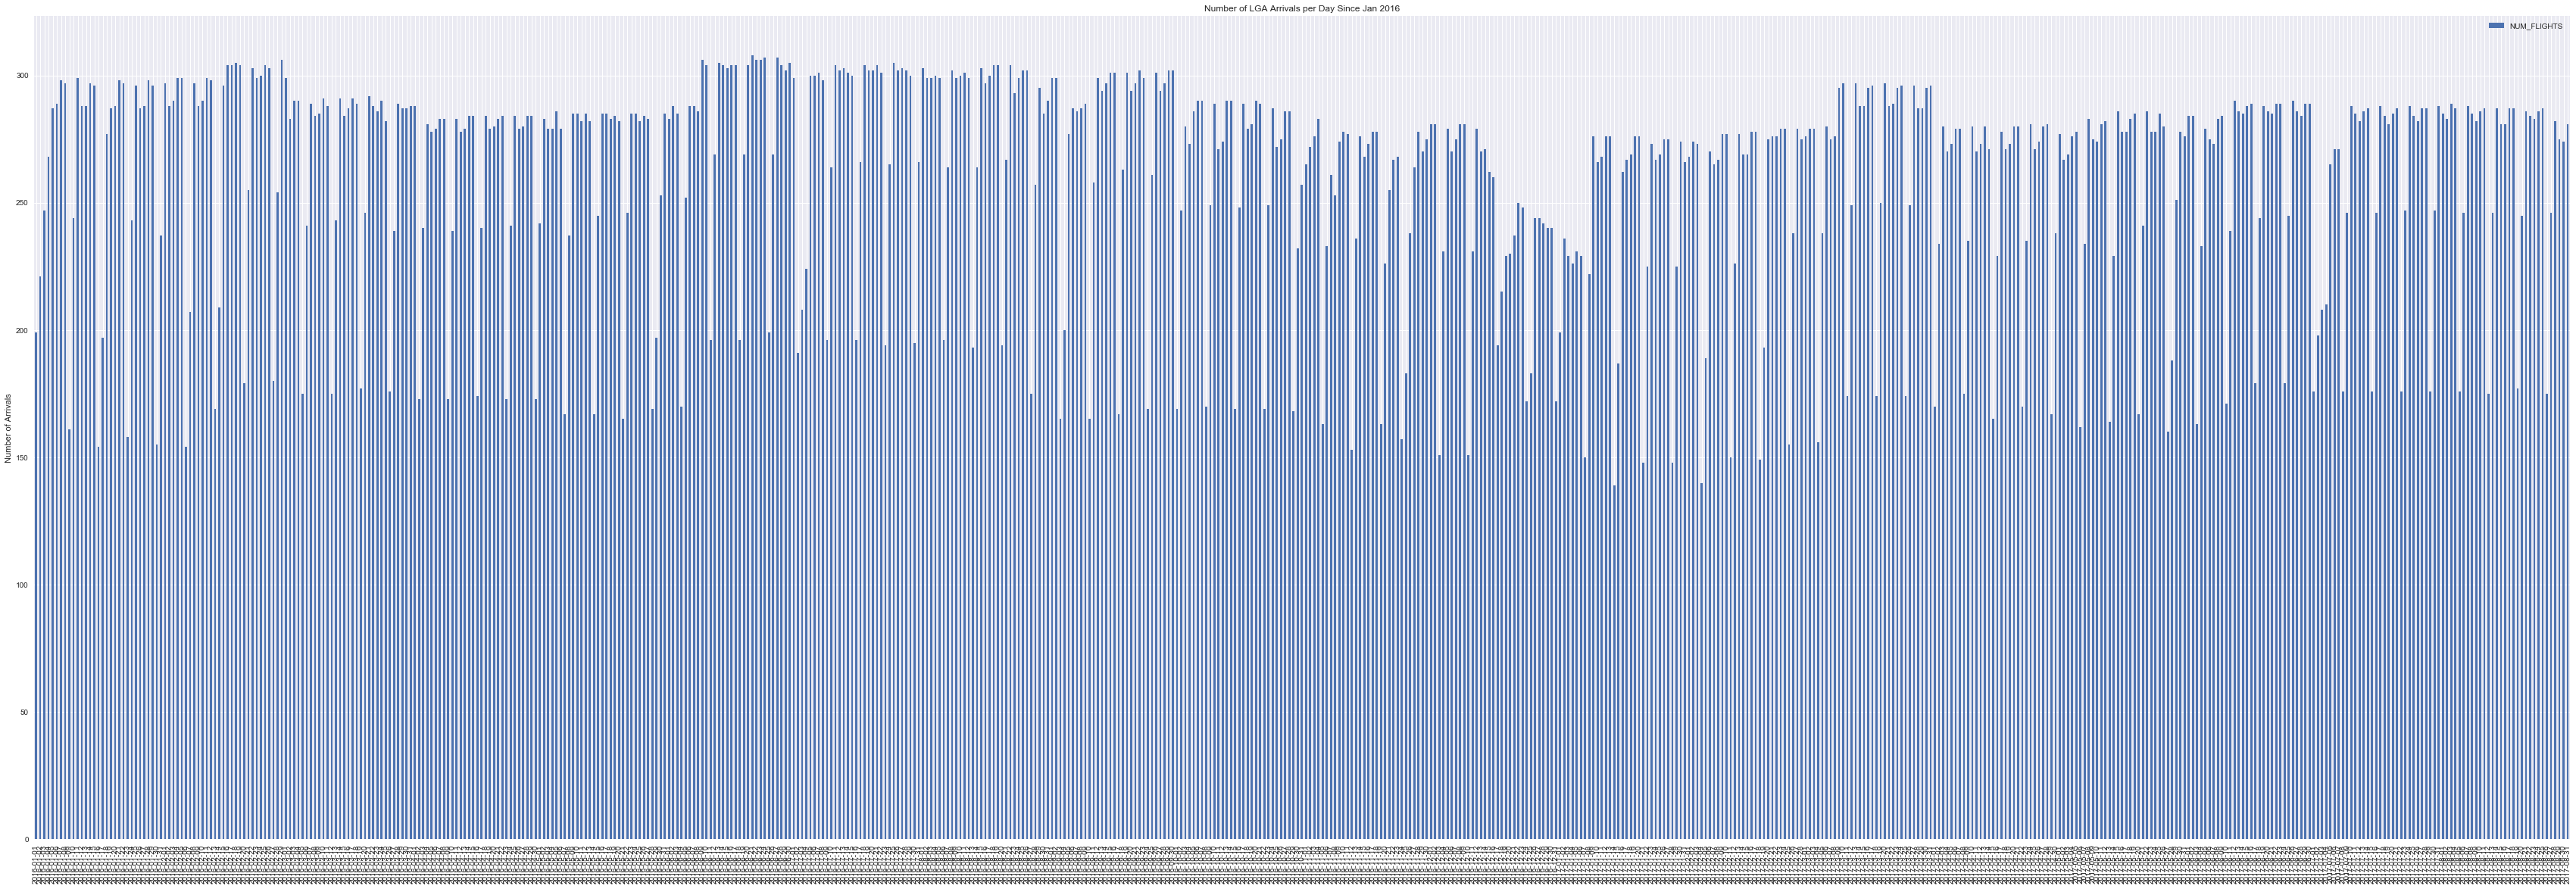

In [49]:
flights_per_day = count_flights_per_day(df)

In [50]:
flights_per_day.head()

,FL_DATE,NUM_FLIGHTS
0,2016-01-01,199
1,2016-01-02,221
2,2016-01-03,247
3,2016-01-04,268
4,2016-01-05,287


### How many flights arrive at LaGuardia per month?

In [51]:
def count_flights_per_month(flights_per_day):
    flights_per_day.index = flights_per_day['FL_DATE'] # Set index to date so we can use TimeGrouper
    flights_per_month = pd.DataFrame(flights_per_day.groupby(pd.TimeGrouper(freq='M')).sum())
    
    # Plot number of arrivals at LGA per month
    ax = flights_per_month.plot(kind='bar', title='Number of LGA Arrivals per Month Since Jan 2016', legend=False, 
                                figsize=(16,8), fontsize=14)
    ax.set_xticklabels(pd.Series(flights_per_month.index).apply(dt.date).apply(lambda x: str(x)[:7])) # removes day and timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    ax.set_xlabel("Month")
    
    return flights_per_month

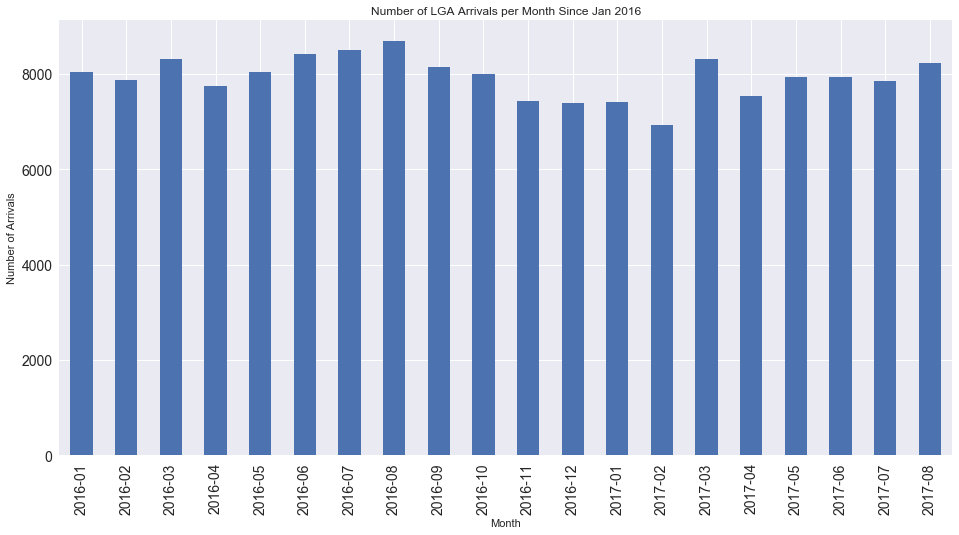

In [52]:
flights_per_month = count_flights_per_month(flights_per_day)

In [53]:
flights_per_month.head()

,NUM_FLIGHTS
FL_DATE,
2016-01-31,8035
2016-02-29,7880
2016-03-31,8302
2016-04-30,7747
2016-05-31,8036


### What is the average number of flights arriving per hour?

Actual arrival time (`ARR_TIME`) comes in a weird format: "hhmm" (local time)

Here's a function to convert "hhmm" format to a datetime time object.

In [134]:
def convert_hhmm_to_time(hhmm):
    hhmm = str(int(hhmm))
    
    if hhmm == '2400': # hour must be btw 0 and 23
        hhmm = '2359'  
    
    if len(hhmm) > 2:  # to handle conversions like '1025' => 10:25:00
        hour = hhmm[:-2]
        minute = hhmm[-2:]
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time) 
        
    if len(hhmm) <= 2: # to handle conversions like '2' => 00:02:00
        hour = "00"
        minute = hhmm.zfill(2)
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time)
        
    return str(time)

Test it out to make sure it works:

In [135]:
convert_hhmm_to_time(1025.0)

'10:25:00'

In [56]:
def calculate_avg_flights_per_hour(df):
    time_stamps = pd.Series(df['ARR_TIME'].dropna())
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    hours = time_stamps.apply(lambda x: x.split(':')[0])
    hours = pd.DataFrame(hours)
    hours.columns = ['ARR_HOUR']
    count_per_hour = hours['ARR_HOUR'].value_counts().sort_index()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_hour = count_per_hour / number_of_days
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_hour.plot(kind='bar', title='Average Number of Arriving Flights per Hour per Day at LaGuardia', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Hour")
    
    return average_per_hour

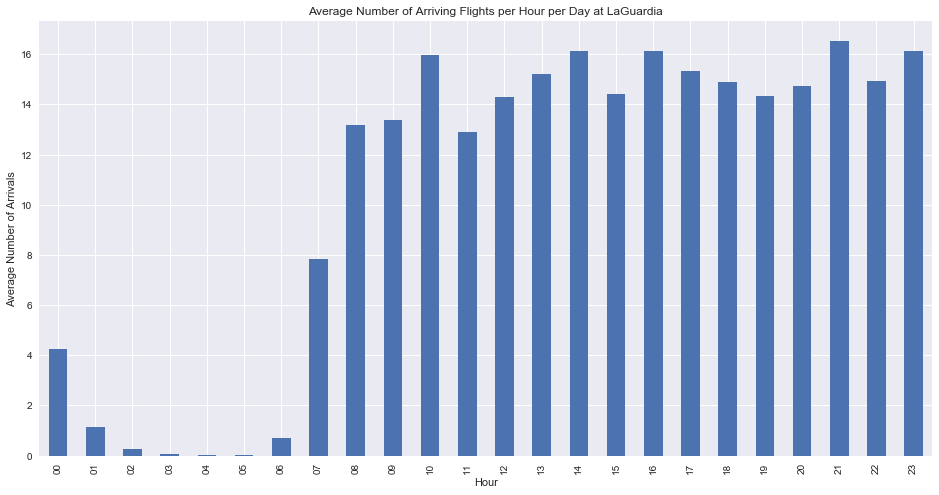

In [57]:
avg_flights_per_hour = calculate_avg_flights_per_hour(df)

In [58]:
avg_flights_per_hour

00     4.241776
01     1.128289
02     0.253289
03     0.054276
04     0.026316
05     0.027961
06     0.680921
07     7.851974
08    13.159539
09    13.363487
10    15.967105
11    12.911184
12    14.300987
13    15.213816
14    16.146382
15    14.424342
16    16.129934
17    15.337171
18    14.889803
19    14.350329
20    14.730263
21    16.511513
22    14.924342
23    16.123355
Name: ARR_HOUR, dtype: float64

### What is the average number of flights arriving by day of week?

In [98]:
days_of_week = {
    "1":"Monday",
    "2":"Tuesday",
    "3":"Wednesday",
    "4":"Thursday",
    "5":"Friday",
    "6":"Saturday",
    "7":"Sunday",
    "9":"Unknown"
}

In [99]:
# https://stackoverflow.com/questions/43692340/how-to-find-number-of-mondays-or-any-other-weekday-between-two-dates-in-python
def weekday_count(start, end):
    start_date  = datetime.datetime.strptime(start, '%Y-%m-%d')
    end_date    = datetime.datetime.strptime(end, '%Y-%m-%d')
    week        = {}
    for i in range((end_date - start_date).days):
        day       = calendar.day_name[(start_date + datetime.timedelta(days=i+1)).weekday()]
        week[day] = week[day] + 1 if day in week else 1
    return week

print(weekday_count("2017-01-01", "2017-01-31"))

{'Monday': 5, 'Tuesday': 5, 'Friday': 4, 'Wednesday': 4, 'Thursday': 4, 'Sunday': 4, 'Saturday': 4}


In [100]:
def calculate_avg_flights_per_day_of_week(df, days_of_week):
    counts_by_day_of_week = df['DAY_OF_WEEK'].value_counts().sort_index()
    minDate = str(df['FL_DATE'].min()).split(" ")[0]
    maxDate = str(df['FL_DATE'].max()).split(" ")[0]
    days_in_range = weekday_count(minDate, maxDate)
    average_per_day_of_week = counts_by_day_of_week / days_in_range['Monday']
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_day_of_week.plot(kind='bar', title='Average Number of Arriving Flights at LaGuardia by Day of Week', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Day of Week")
    xticklabels = [days_of_week[str(i)] for i in list(average_per_day_of_week.index)]
    ax.set_xticklabels(xticklabels)
    
    return days_in_range

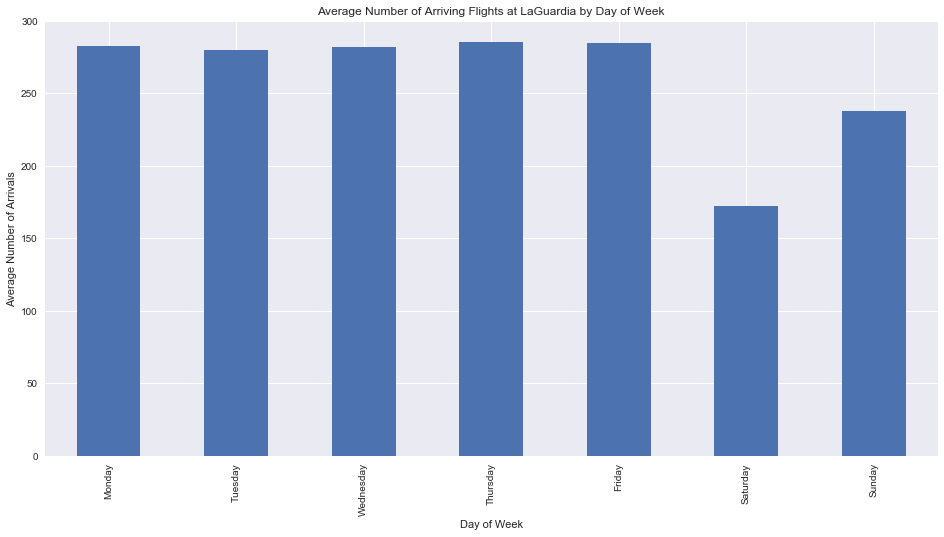

In [101]:
avg_flights_per_day = calculate_avg_flights_per_day_of_week(df, days_of_week)

# Number of Flights per hour since 2016

In [102]:
def count_flights_per_hour(df):
    data = df.copy()
    data = data.dropna(subset=['ARR_TIME'])
    data = data.reset_index(drop=True)
    time_stamps = pd.Series(data['ARR_TIME'])
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    data['TIME_STAMP'] = time_stamps
    dates = pd.Series(data['FL_DATE'].apply(lambda x: str(x).split(" ")[0]))
    data['DATE_STRING'] = dates
    data['FL_DATETIME'] = pd.to_datetime(data['DATE_STRING'] + " " + data['TIME_STAMP'])
    
    # Make dataframe of number of flights per hour since 2016
    output = data['FL_DATETIME']
    output.index = data['FL_DATETIME']
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).count().sort_index())
    output.columns = ['NUM_FLIGHTS']
    
    return output

In [103]:
flights_per_hour = count_flights_per_hour(df)

This is the clean hourly flight data that will go into our model.

In [104]:
flights_per_hour.head()

,NUM_FLIGHTS
FL_DATETIME,
2016-01-01 00:00:00,1
2016-01-01 01:00:00,1
2016-01-01 02:00:00,0
2016-01-01 03:00:00,0
2016-01-01 04:00:00,0


Save it to csv.

In [363]:
flights_per_hour.to_csv("../clean_data/flights_per_hour.csv")

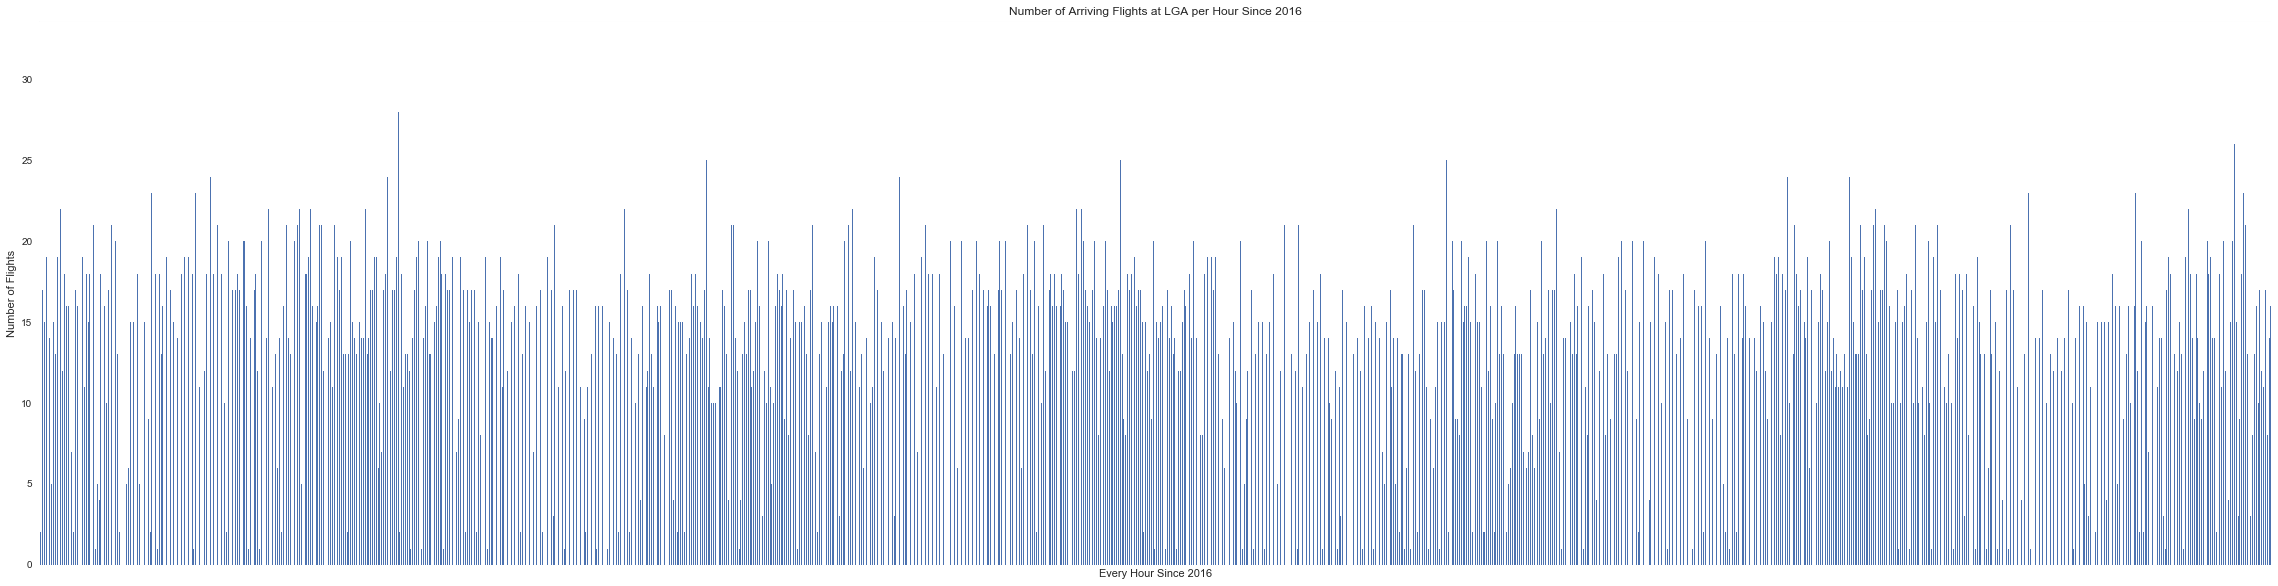

In [362]:
def plot_flights_per_hour():
    ax = flights_per_hour.plot(kind='bar', figsize=(40,10), title='Number of Arriving Flights at LGA per Hour Since 2016', legend=False)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.set_xlabel("Every Hour Since 2016")
    ax.set_ylabel("Number of Flights")
    
plot_flights_per_hour()

# Scrape FAA.gov to Map Tail Numbers to Aircraft Models

http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt=N14249 seems promising.

Make a list of unique tail numbers of flights arriving at LGA.

In [364]:
tail_nums = np.array(df['TAIL_NUM'])
tail_nums = tail_nums[~pd.isnull(tail_nums)] # remove nan's
unique_tail_nums = np.unique(tail_nums) # get unique tail nums
print len(unique_tail_nums), "unique tail numbers arrived at LGA since 2016"

3536 unique tail numbers arrived at LGA since 2016


Test out a scraper using tail number to find manufacturer name and model from http://registry.faa.gov/aircraftinquiry/.

In [30]:
import urllib2
from BeautifulSoup import BeautifulSoup
from collections import defaultdict

In [29]:
tail_num = "N14249"
print "Tail Number:", tail_num

root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
url = root_url.format(tail_num)
req = urllib2.Request(url)
html = urllib2.urlopen(req).read()
soup = BeautifulSoup(html)

# Get manufacturer
manufacturer = soup.find("span", id="content_lbMfrName").text
print "Manufacturer:", manufacturer

# Get aircraft model
model = soup.find("span", id='content_Label7').text
print "Model:", model

Tail Number: N14249
Manufacturer: BOEING
Model: 737-824


This seems to work! Turn it into a function and try running it for all the unique tail numbers.

In [67]:
def match_tail_num_to_model(unique_tail_nums):
    
    count = 0

    results = defaultdict(dict)
    failures = []
    root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
    
    for tail_num in unique_tail_nums:
        if count % 10 == 0:
            print count
        
        url = root_url.format(tail_num)
        req = urllib2.Request(url)
        html = urllib2.urlopen(req).read()
        soup = BeautifulSoup(html)

        try:
            # Get manufacturer
            manufacturer = soup.find("span", id="content_lbMfrName").text
            results[tail_num]['manufacturer'] = manufacturer

            # Get aircraft model
            model = soup.find("span", id='content_Label7').text
            results[tail_num]['model'] = model
            
            # Get airline
            airline = soup.find("span", id='content_lbOwnerName').text
            results[tail_num]['airline'] = airline
        
        except:
            failures.append(tail_num)
            
        count += 1
            
    return results, failures

In [68]:
tail_num_models, tail_num_unknown = match_tail_num_to_model(unique_tail_nums)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [69]:
tail_num_models_df = pd.DataFrame(tail_num_models).transpose()

In [70]:
tail_num_models_df

,airline,manufacturer,model
7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8
7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P
N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B
N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214
N103AA,SMITH GEORGE BARKER,AVIAT AIRCRAFT INC,A-1B
N103SY,SKYWEST AIRLINES INC,EMBRAER S A,ERJ 170-200 LR
N103US,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214
N104UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214
N10575,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145LR
N105AA,WEHRMACHER JAMES P,CESSNA,R182


In [71]:
print "Found model names for {} tail numbers".format(len(tail_num_models_df))

Found model names for 3011 tail numbers


In [72]:
print "Failed to find model names for {} tail numbers:".format(len(tail_num_unknown))
tail_num_unknown

Failed to find model names for 525 tail numbers:


['N001AA',
 'N002AA',
 'N003AA',
 'N004AA',
 'N005AA',
 'N009AA',
 'N012AA',
 'N013AA',
 'N014AA',
 'N015AA',
 'N018AA',
 'N020AA',
 'N021AA',
 'N023AA',
 'N024AA',
 'N028AA',
 'N030AA',
 'N031AA',
 'N032AA',
 'N101NK',
 'N104AA',
 'N107AA',
 'N119AA',
 'N121AA',
 'N126AA',
 'N12921',
 'N12924',
 'N155AA',
 'N165AA',
 'N169AA',
 'N170AA',
 'N177AA',
 'N184AA',
 'N185AA',
 'N208FR',
 'N209FR',
 'N214FR',
 'N301DN',
 'N361AA',
 'N361SW',
 'N3AAAA',
 'N3ABAA',
 'N3ACAA',
 'N3ADAA',
 'N3AEAA',
 'N3AFAA',
 'N3AGAA',
 'N3AHAA',
 'N3AJAA',
 'N3AKAA',
 'N3ALAA',
 'N3AMAA',
 'N3ANAA',
 'N3APAA',
 'N3ARAA',
 'N3ASAA',
 'N3ATAA',
 'N3AUAA',
 'N3AVAA',
 'N3AWAA',
 'N3AXAA',
 'N3AYAA',
 'N3BAAA',
 'N3BBAA',
 'N3BCAA',
 'N3BDAA',
 'N3BEAA',
 'N3BFAA',
 'N3BGAA',
 'N3BHAA',
 'N3BJAA',
 'N3BKAA',
 'N3BLAA',
 'N3BMAA',
 'N3BNAA',
 'N3BPAA',
 'N3BRAA',
 'N3BSAA',
 'N3BTAA',
 'N3BUAA',
 'N3BVAA',
 'N3BWAA',
 'N3BXAA',
 'N3BYAA',
 'N3CAAA',
 'N3CBAA',
 'N3CCAA',
 'N3CDAA',
 'N3CEAA',
 'N3CFAA',
 'N3CGAA',

In [73]:
# Save to csv
tail_num_models_df.to_csv("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model.csv")

In [105]:
def read_tail_num_models(path_to_data):
    tail_num_models_df = pd.read_csv("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model.csv")
    tail_num_models_df = tail_num_models_df.rename(columns={'Unnamed: 0': 'tail_number'})
    tail_num_models_df['manufacturer_short'] = tail_num_models_df['manufacturer'].apply(lambda x: x.split(" ")[0])
    tail_num_models_df['model_short'] = tail_num_models_df['model'].apply(lambda x: x.split("-")[0])
    tail_num_models_df['manufacturer_model'] = tail_num_models_df['manufacturer_short'] + " " + tail_num_models_df['model_short']
    return tail_num_models_df

In [106]:
tail_num_models_df = read_tail_num_models("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model.csv")

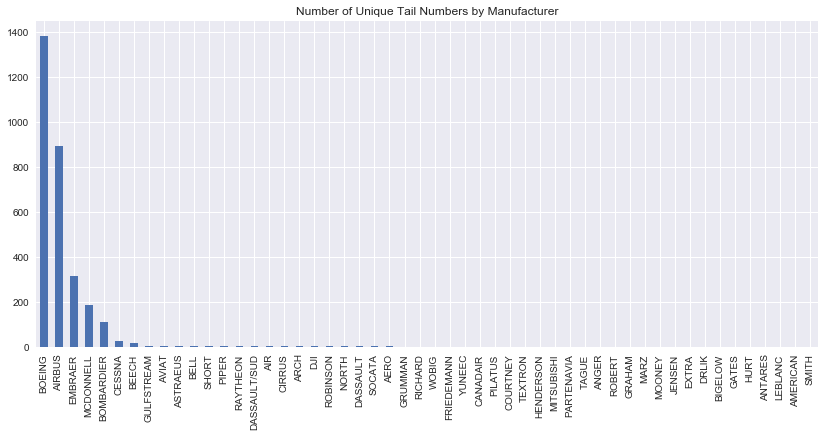

In [107]:
tail_num_models_df['manufacturer_short'].value_counts().plot(kind='bar', figsize=(14,6),
                                                            title='Number of Unique Tail Numbers by Manufacturer');

# Mapping Aircraft Models to Seat Counts

Adam scraped a data base of aircraft models and seats. Let's try to match those to the unique tail numbers found above.

In [108]:
from fuzzywuzzy import fuzz

In [109]:
def read_seat_capacity_data(path_to_data):
    seat_capacity = pd.read_csv(path_to_data)
    del seat_capacity['Unnamed: 0']
    
    seat_capacity['Manufacturer_Short'] = seat_capacity['Aircraft'].apply(lambda x: x.split("-")[0].split(" ")[:1][0])
    seat_capacity['Manufacturer_Model'] = seat_capacity['Aircraft'].apply(lambda x: x.split("-")[0].split("(")[0])
    seat_capacity['Model'] = seat_capacity['Aircraft'].apply(lambda x: x.split("(")[0].split(" ")[1])
    seat_capacity['Model_Short'] = seat_capacity['Model'].apply(lambda x: x.split("-")[0])

    # Do some stuff to deal with weird Embraer naming conventions
    model_short_numbers = []
    for i in seat_capacity.index:
        model_short = seat_capacity.loc[i]['Model_Short']
        model_short_num = re.findall('\d+', seat_capacity.loc[i]['Model_Short'])
        if len(model_short_num) == 0:
            model_short_num = re.findall('\d+', seat_capacity.loc[i]['Model'])
        try: 
            model_short_num = model_short_num[0]
        except:
            model_short_num = np.nan
        model_short_numbers.append(model_short_num)

    seat_capacity['Model_Short_Number'] = model_short_numbers
    return seat_capacity

In [110]:
seat_capacity = read_seat_capacity_data("../raw_data/seat_capacity/seat_capacity.csv")

In [111]:
seat_capacity.head()

,Airline,Aircraft,Seats,Manufacturer_Short,Manufacturer_Model,Model,Model_Short,Model_Short_Number
0,American_Airlines,Airbus A330-200 (332),258,Airbus,Airbus A330,A330-200,A330,330
1,American_Airlines,Airbus A330-300 (333),291,Airbus,Airbus A330,A330-300,A330,330
2,American_Airlines,Boeing 767-300 (763) V1,218,Boeing,Boeing 767,767-300,767,767
3,American_Airlines,Boeing 767-300 (763) V2,209,Boeing,Boeing 767,767-300,767,767
4,American_Airlines,Boeing 777-200 (777) V1,247,Boeing,Boeing 777,777-200,777,777


In [112]:
def match_tail_num_to_seat_capacity(tail_num_models_df, seat_capacity):

    seats_list = []
    seats_unknown = []

    for i in tail_num_models_df.index:

        plane = tail_num_models_df.loc[i]

        # Filter by manufacturer
        filtered = seat_capacity[seat_capacity['Manufacturer_Short'] == plane['manufacturer_short'].title()]

        # Look for exact matching model number
        if plane['model'] in filtered['Model']:
            seats = filtered[filtered['Model'] == plane['model']]['Seats']
            seats_list.append(seats)

        # Else look for matching model_short number and take average seat count
        elif len(filtered[filtered['Model_Short'] == plane['model_short']]) > 0:
            seats = int(np.mean(filtered[filtered['Model_Short'] == plane['model_short']]['Seats']))
            seats_list.append(seats)

        # Handle McDonnell Airlines separately
        elif plane['manufacturer_short'] == 'MCDONNELL':
            filter_mcdonnell = seat_capacity[seat_capacity['Manufacturer_Short'] == 'McDonnell']
            seats = int(np.mean(filter_mcdonnell['Seats']))
            seats_list.append(seats)

        # Handle Embraer separately
        elif plane['manufacturer_short'] == 'EMBRAER':
            filter_embraer = seat_capacity[seat_capacity['Manufacturer_Short'] == 'Embraer']
            model_short_num = re.findall('\d+', plane['model_short'])[0]
            filter_embraer = filter_embraer[filter_embraer['Model_Short_Number'] == model_short_num]
            seats = int(np.mean(filter_embraer['Seats']))
            seats_list.append(seats)
            
        # Handle Bombardier separately
        elif plane['manufacturer_short'] == 'BOMBARDIER':
            filter_bombardier = seat_capacity[seat_capacity['Manufacturer_Short'] == 'Bombardier']
            seats = int(np.mean(filter_bombardier['Seats']))
            seats_list.append(seats)

        else:
            seats_list.append(np.nan)
            seats_unknown.append(plane)
            
    return seats_list, seats_unknown

In [113]:
seats_list, seats_unknown = match_tail_num_to_seat_capacity(tail_num_models_df, seat_capacity)

In [114]:
print len(seats_list) - len(seats_unknown), "tail numbers matched to seat capacity"

2867 tail numbers matched to seat capacity


In [115]:
print len(seats_unknown), "tail numbers with unknown seat capacity"

144 tail numbers with unknown seat capacity


In [116]:
tail_num_models_df['seats'] = seats_list

In [117]:
tail_num_models_df.head(10)

,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model,seats
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8,BOEING,737,BOEING 737,150.0
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P,BOEING,737,BOEING 737,150.0
2,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
3,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
4,N103AA,SMITH GEORGE BARKER,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
5,N103SY,SKYWEST AIRLINES INC,EMBRAER S A,ERJ 170-200 LR,EMBRAER,ERJ 170,EMBRAER ERJ 170,69.0
6,N103US,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
7,N104UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
8,N10575,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145LR,EMBRAER,EMB,EMBRAER EMB,51.0
9,N105AA,WEHRMACHER JAMES P,CESSNA,R182,CESSNA,R182,CESSNA R182,NaN


# Map Individual Flights to Seat Capacities

In [118]:
df = pd.merge(df, tail_num_models_df[['tail_number', 'seats']], left_on='TAIL_NUM', right_on='tail_number', how='left')

In [119]:
df.head(10)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,tail_number,seats
0,2016,1,1,1,5,2016-01-01,NK,20416,NK,N641NK,...,NaN,NaN,NaN,NaN,NaN,850,NaN,NaN,N641NK,156.0
1,2016,1,1,1,5,2016-01-01,NK,20416,NK,N636NK,...,624.0,24.0,24.0,740.0,8.0,735,748.0,13.0,N636NK,156.0
2,2016,1,1,1,5,2016-01-01,B6,20409,B6,N623JB,...,556.0,-4.0,0.0,806.0,5.0,825,811.0,-14.0,N623JB,156.0
3,2016,1,1,1,5,2016-01-01,B6,20409,B6,N599JB,...,553.0,-7.0,0.0,819.0,5.0,841,824.0,-17.0,N599JB,156.0
4,2016,1,1,1,5,2016-01-01,AA,19805,AA,N3KRAA,...,714.0,69.0,69.0,947.0,5.0,857,952.0,55.0,NaN,NaN
5,2016,1,1,1,5,2016-01-01,AA,19805,AA,N127UW,...,610.0,5.0,5.0,735.0,6.0,746,741.0,-5.0,N127UW,156.0
6,2016,1,1,1,5,2016-01-01,B6,20409,B6,N529JB,...,613.0,-2.0,0.0,839.0,7.0,853,846.0,-7.0,N529JB,156.0
7,2016,1,1,1,5,2016-01-01,DL,19790,DL,N933DL,...,627.0,-3.0,0.0,855.0,8.0,929,903.0,-26.0,N933DL,149.0
8,2016,1,1,1,5,2016-01-01,DL,19790,DL,N953DL,...,646.0,1.0,1.0,833.0,10.0,856,843.0,-13.0,N953DL,149.0
9,2016,1,1,1,5,2016-01-01,EV,20366,EV,N391CA,...,647.0,-8.0,0.0,816.0,6.0,855,822.0,-33.0,N391CA,65.0


# Exploratory Data Analysis on Seat Capacities

### How many seats arrive at LaGuardia per day?

In [120]:
def count_seats_per_day(df):
    df = df.copy()
    df.index = df['FL_DATE']
    seats_per_day = df.groupby(pd.TimeGrouper(freq='D'))['seats'].sum()
    
    # Plot number of seats arriving at LGA per day
    ax = seats_per_day.plot(kind='bar', figsize=(60,20), title='Number of Seats Arriving at LGA per Day Since Jan 2016')
    ax.set_xticklabels(pd.Series(seats_per_day.index).apply(dt.date)) # removes timestamp from datetime
    ax.set_ylabel("Number of Seats")
    
    return seats_per_day

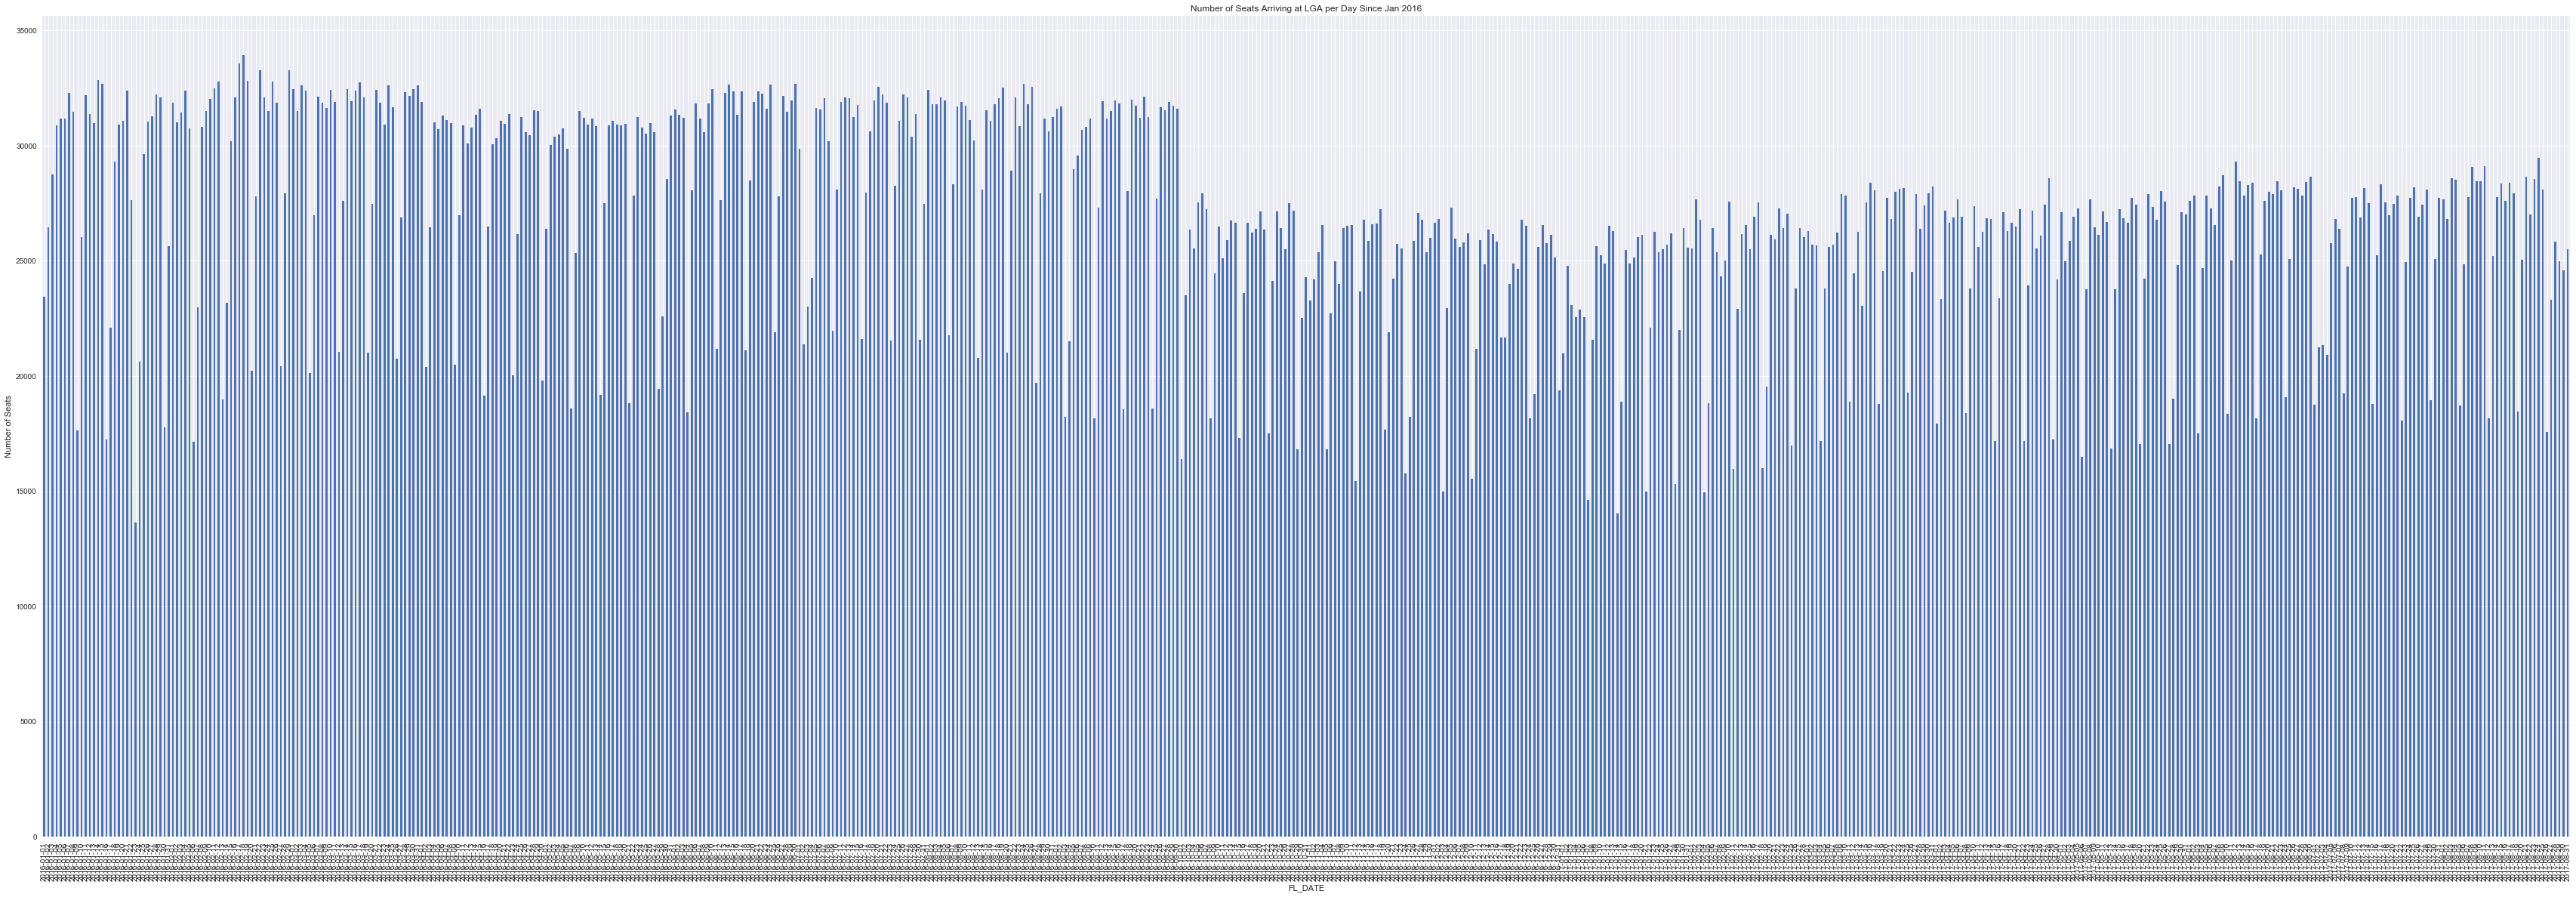

In [121]:
seats_per_day = count_seats_per_day(df)

In [172]:
seats_per_day.head()

FL_DATE
2016-01-01    23457.0
2016-01-02    26469.0
2016-01-03    28762.0
2016-01-04    30869.0
2016-01-05    31162.0
Freq: D, Name: seats, dtype: float64

### How many seats arrive at LaGuardia per month?

In [136]:
def count_seats_per_month(df):
    df = df.copy()
    df.index = df['FL_DATE']
    seats_per_day = df.groupby(pd.TimeGrouper(freq='M'))['seats'].sum()
    
    # Plot number of seats arriving at LGA per day
    ax = seats_per_day.plot(kind='bar', figsize=(16,8), title='Number of Seats Arriving at LGA per Month Since Jan 2016', fontsize=14)
    ax.set_xticklabels(pd.Series(seats_per_day.index).dt.date) # removes timestamp from datetime
    ax.set_ylabel("Number of Seats")
    
    return seats_per_day

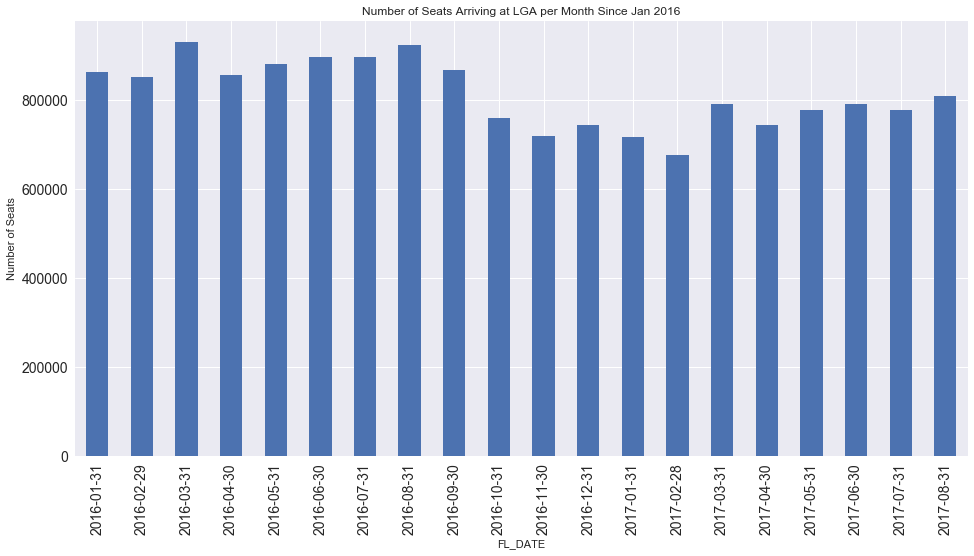

In [137]:
seats_per_month = count_seats_per_month(df)

In [138]:
seats_per_month.head()

FL_DATE
2016-01-31    864039.0
2016-02-29    853153.0
2016-03-31    931468.0
2016-04-30    856919.0
2016-05-31    881628.0
Freq: M, Name: seats, dtype: float64

### What is the average number of seats arriving per hour?

In [168]:
def calculate_avg_seats_per_hour(df):
    
    df = df.copy()
    df = df.dropna()
    time_stamps = df['ARR_TIME']
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    hours = time_stamps.apply(lambda x: x.split(':')[0])
    df['ARR_HOUR'] = hours
    seats_per_hour = df.groupby(by='ARR_HOUR')['seats'].sum()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_hour = seats_per_hour / number_of_days
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_hour.plot(kind='bar', title='Average Number of Arriving Seats per Hour per Day at LaGuardia', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Hour")
    
    return average_per_hour

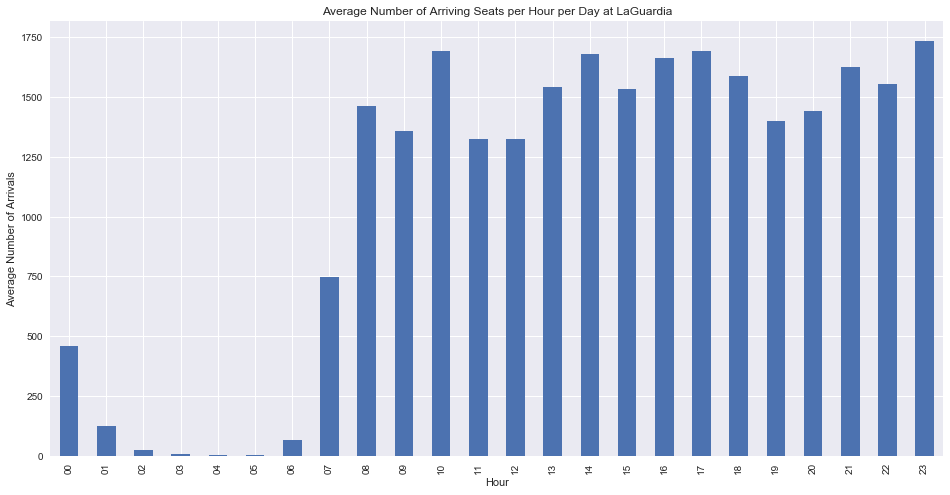

In [169]:
avg_seats_per_hour = calculate_avg_seats_per_hour(df)

In [167]:
avg_seats_per_hour.head()

ARR_HOUR
00    457.708882
01    123.750000
02     25.220395
03      6.200658
04      3.162829
Name: seats, dtype: float64

### What is the average number of seats arriving by day of week?

In [355]:
days_of_week = {
    "1":"Monday",
    "2":"Tuesday",
    "3":"Wednesday",
    "4":"Thursday",
    "5":"Friday",
    "6":"Saturday",
    "7":"Sunday",
    "9":"Unknown"
}

In [180]:
def calculate_avg_seats_per_day_of_week(df, days_of_week):
    
    seats_by_day_of_week = df.groupby(by='DAY_OF_WEEK')['seats'].sum()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    minDate = str(df['FL_DATE'].min()).split(" ")[0]
    maxDate = str(df['FL_DATE'].max()).split(" ")[0]
    days_in_range = weekday_count(minDate, maxDate)
    average_per_day_of_week = seats_by_day_of_week / days_in_range['Monday']

    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_day_of_week.plot(kind='bar', title='Average Number of Arriving Seats at LaGuardia by Day of Week', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Day of Week")
    xticklabels = [days_of_week[str(i)] for i in list(average_per_day_of_week.index)]
    ax.set_xticklabels(xticklabels)

    return average_per_day_of_week

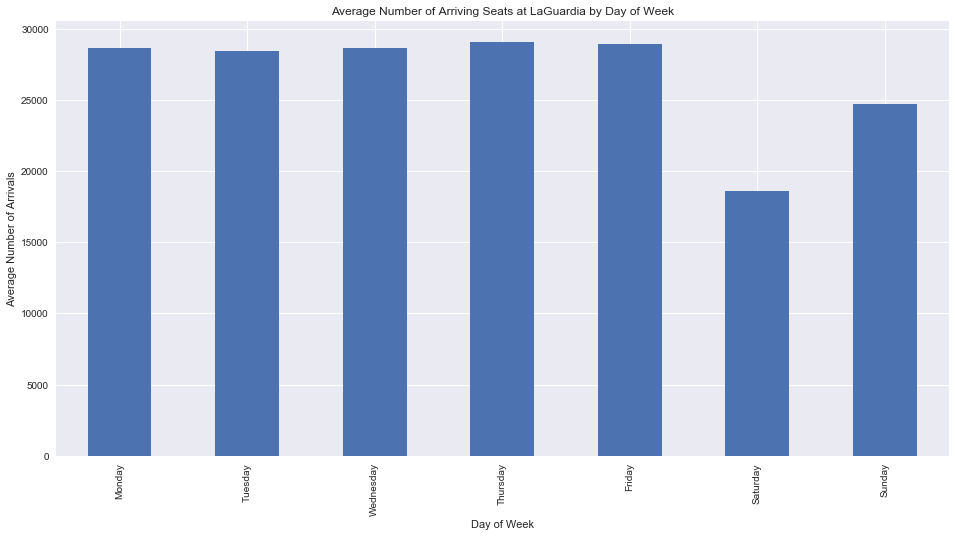

In [181]:
avg_seats_per_day = calculate_avg_seats_per_day_of_week(df, days_of_week)

# Number of Seats per hour since 2016

In [358]:
def count_flights_per_hour(df):
    data = df.copy()
    data = data.dropna(subset=['ARR_TIME'])
    data = data.reset_index(drop=True)
    time_stamps = pd.Series(data['ARR_TIME'])
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    data['TIME_STAMP'] = time_stamps
    dates = pd.Series(data['FL_DATE'].apply(lambda x: str(x).split(" ")[0]))
    data['DATE_STRING'] = dates
    data['FL_DATETIME'] = pd.to_datetime(data['DATE_STRING'] + " " + data['TIME_STAMP'])
    
    # Make dataframe of number of flights per hour since 2016
    output = data['FL_DATETIME']
    output.index = data['FL_DATETIME']
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).count().sort_index())
    output.columns = ['NUM_FLIGHTS']
    
    return output

In [359]:
flights_per_hour = count_flights_per_hour(df)

This is the clean hourly flight data that will go into our model.

In [360]:
flights_per_hour.head()

,NUM_FLIGHTS
FL_DATETIME,
2016-01-01 00:00:00,1
2016-01-01 01:00:00,1
2016-01-01 02:00:00,0
2016-01-01 03:00:00,0
2016-01-01 04:00:00,0


Save it to csv.

In [363]:
flights_per_hour.to_csv("../clean_data/flights_per_hour.csv")

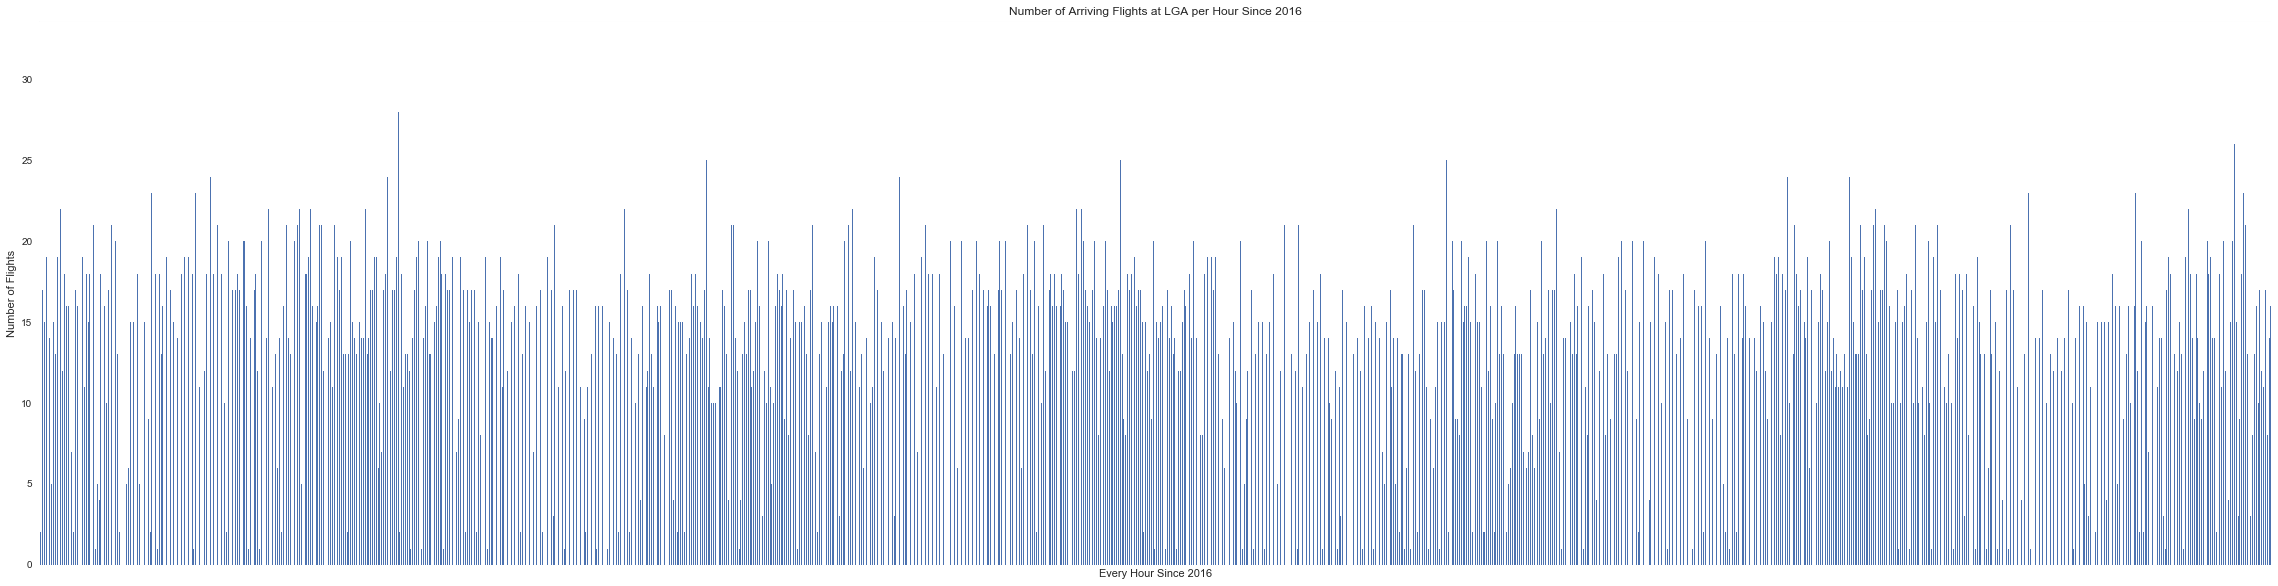

In [362]:
def plot_flights_per_hour():
    ax = flights_per_hour.plot(kind='bar', figsize=(40,10), title='Number of Arriving Flights at LGA per Hour Since 2016', legend=False)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.set_xlabel("Every Hour Since 2016")
    ax.set_ylabel("Number of Flights")
    
plot_flights_per_hour()

# Estimating Seat Utilization (%) by Airline

AviationDB Airline Traffic Query

http://www.aviationdb.com/Aviation/F4SDetailQuery.shtm